<a href="https://colab.research.google.com/github/TIMEdilation584/JP_Loksatta_moving_hearts/blob/master/19_07_22_Model_002_ResNet50_for_AugMelSpec_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.2
/device:GPU:0


In [4]:
cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [5]:
#Specify the folder that contains the training and test data
TRAIN_DIR = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/train/'      # Train 
VAL_DIR = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/val/'          # Validation
TEST_DIR = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/test/'        # Test

### IMAGE GENERATORS
Now declare the Generator functions and the Image Generators to be able to train and test the model:

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size=(465,302),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1008 images belonging to 8 classes.


In [7]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                 target_size=(465,302),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 336 images belonging to 8 classes.


In [8]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 target_size=(465,302),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 336 images belonging to 8 classes.


### About Dataset 

Training shape:  1008 (465, 302, 3)
1008 sample, (465, 302, 3) size RGB image.

Validation shape:  336 (465, 302, 3)
336 sample, (465, 302, 3) size RGB image.

Test shape: 336
336 sample, (465, 302, 3) size RGB image.

Indices Used in Training:  {'Cargo': 0, 'Passengership': 1, 'Sonar': 2, 'Submarine': 3, 'Surfaceship': 4, 'Tanker': 5, 'Torpedo': 6, 'Tug': 7} 

Indices Used in Testing:  {'Cargo': 0, 'Passengership': 1, 'Sonar': 2, 'Submarine': 3, 'Surfaceship': 4, 'Tanker': 5, 'Torpedo': 6, 'Tug': 7} 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Per Batch Images:  (16, 465, 302, 3)
Per Batch labels:  (16, 8)
Examples:


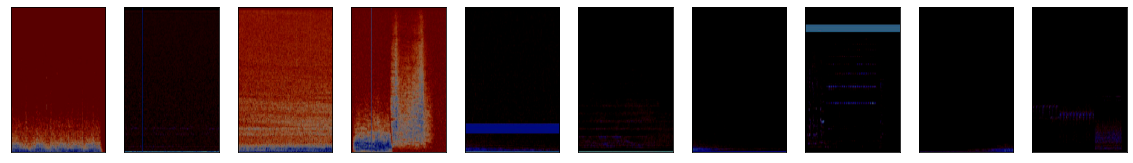

In [9]:
print('Training shape: ', train_generator.samples , train_generator.image_shape)
print(train_generator.n , 'sample,',train_generator.image_shape ,'size RGB image.\n')

print('Validation shape: ', validation_generator.samples , validation_generator.image_shape)
print(validation_generator.n , 'sample,',validation_generator.image_shape ,'size RGB image.\n')

print('Test shape:', test_generator.samples)
print(test_generator.n , 'sample,',test_generator.image_shape ,'size RGB image.\n')

print("Indices Used in Training: ", train_generator.class_indices, '\n')
print("Indices Used in Testing: ", test_generator.class_indices, '\n')

x_batch,y_batch = next(train_generator) 
print('Per Batch Images: ', x_batch.shape)
print('Per Batch labels: ', y_batch.shape)   

print('Examples:')
n = 10

plt.figure(figsize=(20, 4))
x_batch = x_batch.astype("float32") / 255.0
for i in range(1, n+1):
    # Display some data:
    ax = plt.subplot(1, n, i)
    plt.imshow(x_batch[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Model Defination

In [10]:
import datetime
import pandas as pd
import numpy as np
from tensorflow.keras.applications import vgg16, vgg19, MobileNetV2, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models , regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.optimizers import Adam, RMSprop,SGD,Adamax
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [11]:
#batch_size = 32
epochs = 100
num_classes = train_generator.num_classes
num_classes

8

In [12]:
# set up transfer learning on pre-trained ImageNet ResNet50 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
resn_model = ResNet50(weights = 'imagenet', include_top = False)
x = resn_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model_ = Model(resn_model.input, predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [13]:
# freeze all layers of the pre-trained model
for layer in resn_model.layers:
    layer.trainable = False

In [14]:
model_.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [15]:
#model_.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# compile the new model using a RMSProp optimizer
model_.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
step_size_train=train_generator.n//train_generator.batch_size+1
step_size_val=validation_generator.n//validation_generator.batch_size+1

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger

In [18]:
erly_stoping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8) 
csv_logger = CSVLogger('History/history_resnet50_AugMelSpec.log')

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
with tf.device('/gpu:0'):
    history = model_.fit(
                    train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_val,
                    verbose=True,
                    callbacks=[erly_stoping])  #, csv_logger])
    # save transfer learning model for offline prediction purposes
    #model.save('AugMelSpec_resnet50_model_tl.h5')

print('Training time: %s' % (now() - t))

Epoch 1/100
64/64 [==============================] - 277s 4s/step - loss: 2.3619 - accuracy: 0.4365 - val_loss: 1.1386 - val_accuracy: 0.5685
Training time: 0:05:25.056079


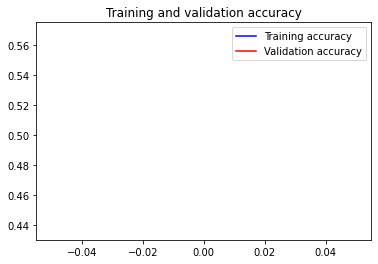

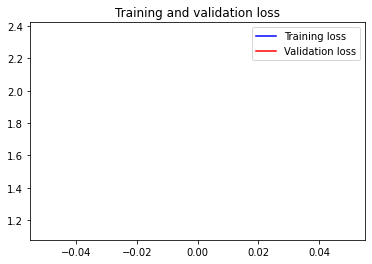

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochss = range(len(accuracy))
plt.plot(epochss, accuracy, 'b', label='Training accuracy')
plt.plot(epochss, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochss, loss, 'b', label='Training loss')
plt.plot(epochss, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
val_eval = model_.evaluate(validation_generator, verbose=0)
val_eval

[1.1386126279830933, 0.5684523582458496]

In [22]:
classes = ["Cargo", "Passengrship", "Tanker", "Tug","s","t","u","v"]

In [23]:
predicted_classes = model_.predict(validation_generator)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [24]:
cm = confusion_matrix(validation_generator.classes,predicted_classes)
    
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[31  0  0  0  0  5  0  0]
 [31 15  0  0  0 14  0  0]
 [ 0  0 18  0  0  0  0  0]
 [23  0 14 15 26  0  0  0]
 [ 0  0  0  0 27  0  0  0]
 [41  2  1  0  2 38  0  0]
 [ 9  0  1  1  3  0 10  0]
 [ 8  0  0  0  0  1  0  0]]


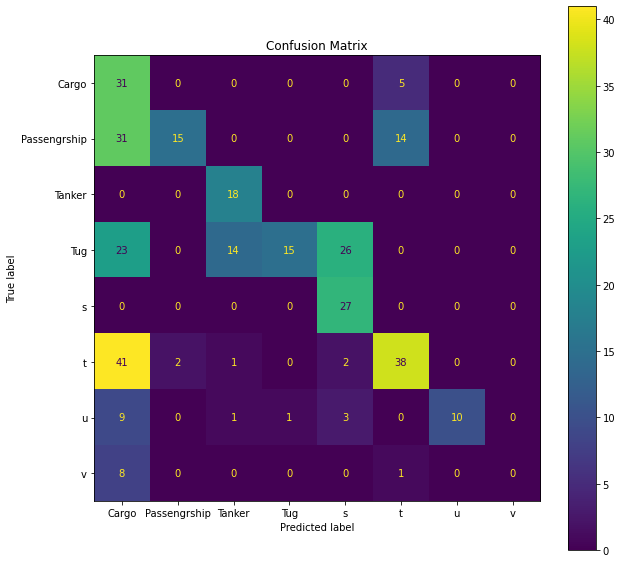

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix")
disp = disp.plot(ax=ax)
plt.show()

In [26]:
print('Classification Report')
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print(classification_report(validation_generator.classes, predicted_classes, target_names=classes))

Classification Report
              precision    recall  f1-score   support

       Cargo       0.22      0.86      0.35        36
Passengrship       0.88      0.25      0.39        60
      Tanker       0.53      1.00      0.69        18
         Tug       0.94      0.19      0.32        78
           s       0.47      1.00      0.64        27
           t       0.66      0.45      0.54        84
           u       1.00      0.42      0.59        24
           v       0.00      0.00      0.00         9

    accuracy                           0.46       336
   macro avg       0.59      0.52      0.44       336
weighted avg       0.70      0.46      0.44       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
test_eval = model_.evaluate(test_generator, verbose=0)
test_eval

[1.7100750207901, 0.318452388048172]

In [28]:
classes = ["Cargo", "Passengrship", "Tanker", "Tug","s","t","u","v"]

In [29]:
predicted_classes = model_.predict(test_generator)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [30]:
cm = confusion_matrix(test_generator.classes,predicted_classes)
    
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[25  0  1  0  4  6  0  0]
 [41  0  7  0  8  4  0  0]
 [ 0  0 15  0  3  0  0  0]
 [24  0 23  5 26  0  0  0]
 [ 7  0  4  0 16  0  0  0]
 [50  0  6  0 11 17  0  0]
 [ 9  0  3  0  9  0  3  0]
 [ 4  0  0  0  1  4  0  0]]


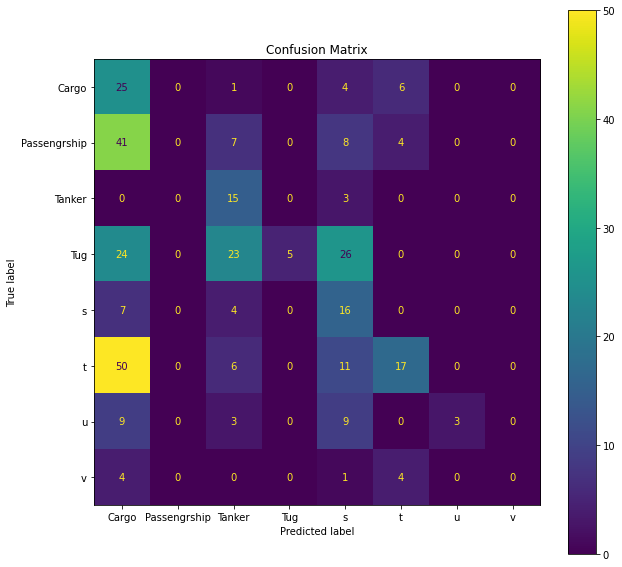

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix")
disp = disp.plot(ax=ax)
plt.show()

In [32]:
print('Classification Report')
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print(classification_report(validation_generator.classes, predicted_classes, target_names=classes))

Classification Report
              precision    recall  f1-score   support

       Cargo       0.16      0.69      0.26        36
Passengrship       0.00      0.00      0.00        60
      Tanker       0.25      0.83      0.39        18
         Tug       1.00      0.06      0.12        78
           s       0.21      0.59      0.30        27
           t       0.55      0.20      0.30        84
           u       1.00      0.12      0.22        24
           v       0.00      0.00      0.00         9

    accuracy                           0.24       336
   macro avg       0.40      0.31      0.20       336
weighted avg       0.49      0.24      0.19       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine Tuning the model

In [33]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG16 model - train all layers
for layer in model_.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model_.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()

with tf.device('/gpu:0'):
    history = model_.fit(
                    train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_val,
                    verbose=True,
                    callbacks=[erly_stoping])  #, csv_logger])
    # save fine-tuning model for offline prediction purposes
    #model_.save('Models/AugMelSpec_resnet50_model_ft.h5')

print('Training time: %s' % (now() - t))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


64/64 [==============================] - 43s 547ms/step - loss: 2.1570 - accuracy: 0.4177 - val_loss: 1.0704 - val_accuracy: 0.5179
Training time: 0:00:42.705715


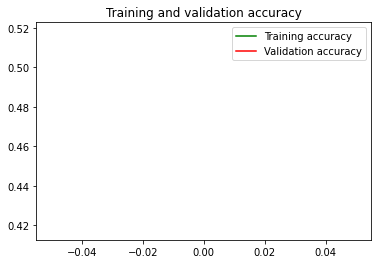

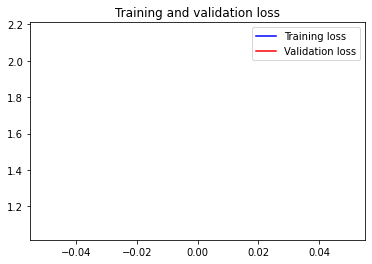

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochss = range(len(accuracy))
plt.plot(epochss, accuracy, 'g', label='Training accuracy')
plt.plot(epochss, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochss, loss, 'b', label='Training loss')
plt.plot(epochss, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
val_eval = model_.evaluate(validation_generator, verbose=1)
val_eval

21/21 [==============================] - 3s 155ms/step - loss: 1.0704 - accuracy: 0.5179


[1.0704283714294434, 0.5178571343421936]

In [36]:
classes = ["Cargo", "Passengrship", "Tanker", "Tug","s","t","u","v"]

In [37]:
predicted_classes = model_.predict(validation_generator)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [38]:
cm = confusion_matrix(validation_generator.classes,predicted_classes)
    
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[23 10  0  0  0  3  0  0]
 [ 9 32  0  0  0 19  0  0]
 [ 1  0 15  0  0  0  2  0]
 [42  0  5 21  6  0  4  0]
 [ 5  0  0  0 22  0  0  0]
 [15 36  0  0  1 32  0  0]
 [ 6  0  0  1  0  0 17  0]
 [ 0  7  0  0  0  2  0  0]]


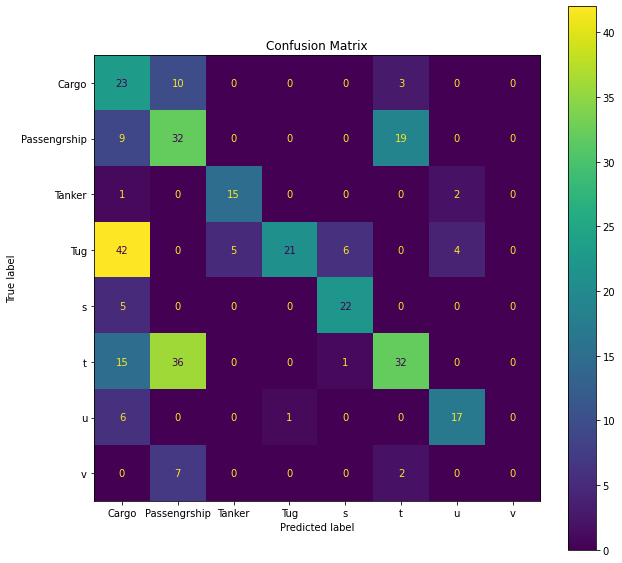

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix")
disp = disp.plot(ax=ax)
plt.show()

In [40]:
print('Classification Report')
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print(classification_report(validation_generator.classes, predicted_classes, target_names=classes))

Classification Report
              precision    recall  f1-score   support

       Cargo       0.23      0.64      0.34        36
Passengrship       0.38      0.53      0.44        60
      Tanker       0.75      0.83      0.79        18
         Tug       0.95      0.27      0.42        78
           s       0.76      0.81      0.79        27
           t       0.57      0.38      0.46        84
           u       0.74      0.71      0.72        24
           v       0.00      0.00      0.00         9

    accuracy                           0.48       336
   macro avg       0.55      0.52      0.49       336
weighted avg       0.61      0.48      0.48       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
test_eval = model_.evaluate(test_generator, verbose=0)
test_eval

[1.1406946182250977, 0.5267857313156128]

In [42]:
classes = ["Cargo", "Passengrship", "Tanker", "Tug","s","t","u","v"]

In [43]:
predicted_classes = model_.predict(test_generator)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [44]:
cm = confusion_matrix(test_generator.classes,predicted_classes)
    
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[15 12  0  0  0  9  0  0]
 [21 32  0  0  0  7  0  0]
 [ 2  0 14  0  2  0  0  0]
 [39  0  5 27  5  0  2  0]
 [19  0  0  1  7  0  0  0]
 [27 32  0  0  0 25  0  0]
 [11  0  0  3  0  0 10  0]
 [ 6  3  0  0  0  0  0  0]]


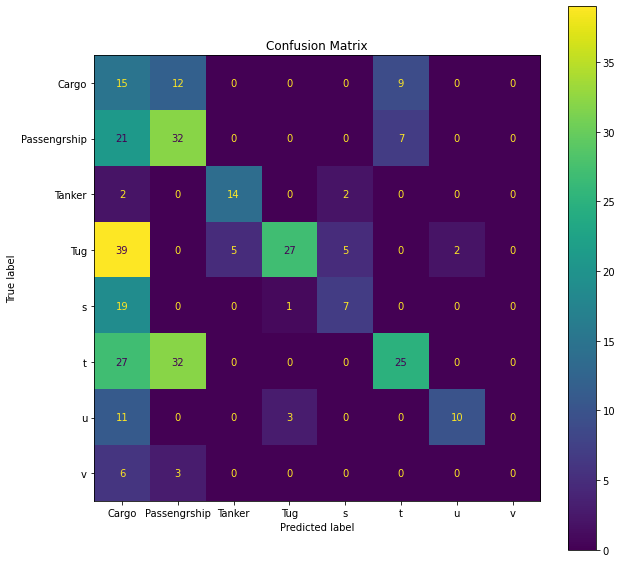

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix")
disp = disp.plot(ax=ax)
plt.show()

In [46]:
print('Classification Report')
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print(classification_report(validation_generator.classes, predicted_classes, target_names=classes))

Classification Report
              precision    recall  f1-score   support

       Cargo       0.11      0.42      0.17        36
Passengrship       0.41      0.53      0.46        60
      Tanker       0.74      0.78      0.76        18
         Tug       0.87      0.35      0.50        78
           s       0.50      0.26      0.34        27
           t       0.61      0.30      0.40        84
           u       0.83      0.42      0.56        24
           v       0.00      0.00      0.00         9

    accuracy                           0.39       336
   macro avg       0.51      0.38      0.40       336
weighted avg       0.58      0.39      0.42       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
